In [32]:
import torch # Import the torch module

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Now you can access files in your Drive, e.g., '/content/drive/My Drive/path/to/your/pdfs/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install langchain langchain-community langchain-huggingface langchain-text-splitters \
             pypdf pymupdf # PyPDFLoader and PyMuPDFLoader often rely on these
!pip install faiss-cpu sentence-transformers transformers torch torchvision \
             Pillow pytesseract pdf2image # For embeddings & image handling
!apt-get update
!apt-get install -y tesseract-ocr libtesseract-dev poppler-utils # For OCR & pdf2image

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [5]:
# --- Phase 4: Language Model Integration (Using User-Provided Mistral Loading/Inference - Corrected) ---

# 1. Install necessary libraries
# Ensure accelerate and bitsandbytes are installed
!pip install -q transformers accelerate bitsandbytes huggingface_hub --quiet
print("Installed/Checked transformers, accelerate, bitsandbytes, and huggingface_hub.")
print("--> IMPORTANT: If this is the first time running after install, please RESTART RUNTIME (Runtime > Restart runtime...) before running again! <--")


# --- Import necessary libraries ---
from huggingface_hub import notebook_login, HfFolder
import os
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig # Import BitsAndBytesConfig
import torch

# --- Hugging Face Token Handling ---
# (Re-run login if runtime was restarted)
hf_token = None
try:
    from google.colab import userdata
    hf_token = userdata.get('HF_TOKEN')
    if hf_token:
        print("Hugging Face token found in Colab secrets.")
        HfFolder.save_token(hf_token)
        os.environ["HF_TOKEN"] = hf_token
    else:
        print("HF_TOKEN secret not found in Colab. Please login manually.")
        notebook_login()
except ImportError:
    print("Not in Colab environment or secrets unavailable. Please login manually.")
    notebook_login()
except Exception as e:
    print(f"An error occurred during token handling: {e}")
    print("Attempting manual login...")
    notebook_login()



Installed/Checked transformers, accelerate, bitsandbytes, and huggingface_hub.
--> IMPORTANT: If this is the first time running after install, please RESTART RUNTIME (Runtime > Restart runtime...) before running again! <--
Hugging Face token found in Colab secrets.


In [6]:

# --- Configuration ---
llm_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
max_new_tokens = 512

# --- 3. Initialize LLM and Tokenizer (Corrected Loading) ---
print(f"Initializing Tokenizer and Model: {llm_model_id}")
print("NOTE: This will download model weights (~14GB) if not cached and may take time.")
print("Ensure you are using a GPU runtime (e.g., T4).")

# Define quantization config first
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # Or torch.float16 depending on GPU
    bnb_4bit_use_double_quant=False,
)


Initializing Tokenizer and Model: mistralai/Mistral-7B-Instruct-v0.1
NOTE: This will download model weights (~14GB) if not cached and may take time.
Ensure you are using a GPU runtime (e.g., T4).


In [7]:

# Define model and tokenizer variables outside try block
model = None
tokenizer = None
device = "cpu" # Default to CPU

try:
    tokenizer = AutoTokenizer.from_pretrained(llm_model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load model using ONLY quantization_config
    model = AutoModelForCausalLM.from_pretrained(
        llm_model_id,
        quantization_config=bnb_config, # Use the config object
        device_map="auto",
        torch_dtype=torch.bfloat16, # Match compute dtype if possible
        trust_remote_code=True
        # REMOVED load_in_4bit=True (now handled by quantization_config)
    )
    print("Model loaded successfully.")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Model loaded. Inputs will be sent to: {device}")

except ImportError:
    print("ERROR: bitsandbytes library not found or import failed. Cannot load in 4-bit.")
    print("Please ensure the first cell ran correctly AND you RESTARTED THE RUNTIME.")
except Exception as e:
    print(f"Error initializing LLM/Tokenizer: {e}")


# --- 4. Create Prompt Template (Mistral Instruct Format) ---
prompt_template_str_mistral = """<s>[INST] You are an assistant tasked with answering questions based ONLY on the context provided below.
If the context does not contain the answer, state "Based on the provided context, I cannot answer the question.".
Do not use any prior knowledge. Be concise.

Context:
{context}

Question: {question} [/INST]
"""
rag_prompt = PromptTemplate.from_template(prompt_template_str_mistral)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded successfully.
Model loaded. Inputs will be sent to: cuda


In [8]:
from langchain_community.document_loaders import PyMuPDFLoader
import os

pdf_directory = '/content/drive/MyDrive/Semester #8/Gen Ai/A3/Data' # *** Replace with your PDF folder path ***
all_pdf_docs = []

print("Loading PDF documents using LangChain PyMuPDFLoader...")
for filename in os.listdir(pdf_directory):
    if filename.lower().endswith(".pdf"):
        filepath = os.path.join(pdf_directory, filename)
        print(f"Loading: {filename}")
        try:
            loader = PyMuPDFLoader(filepath)
            docs = loader.load() # Loads pages as separate LangChain Documents
            # Add filename to metadata for clarity if needed (loader might already do this)
            for doc in docs:
                doc.metadata['source_pdf'] = filename
            all_pdf_docs.extend(docs)
            print(f" -> Loaded {len(docs)} pages.")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

print(f"\nTotal LangChain Documents loaded from PDFs: {len(all_pdf_docs)}")
# Optional: Inspect a loaded document
# if all_pdf_docs:
#    print("\nSample loaded document (first page):")
#    print(all_pdf_docs[0])

Loading PDF documents using LangChain PyMuPDFLoader...
Loading: 2. financials.pdf
 -> Loaded 35 pages.
Loading: 1. Annual Report 2023-24.pdf
 -> Loaded 85 pages.
Loading: 3. FYP-Handbook-2023.pdf
 -> Loaded 62 pages.

Total LangChain Documents loaded from PDFs: 182


In [9]:
import fitz # PyMuPDF
from PIL import Image
import pytesseract
import io
from langchain_core.documents import Document

image_output_dir = '/content/extracted_images_lc' # Use a distinct directory if needed
if not os.path.exists(image_output_dir):
    os.makedirs(image_output_dir)

image_docs = []

print("\nExtracting images and performing OCR...")
pdf_directory = '/content/drive/MyDrive/Semester #8/Gen Ai/A3/Data' # *** Make sure this path is correct ***

for filename in os.listdir(pdf_directory):
    if filename.lower().endswith(".pdf"):
        filepath = os.path.join(pdf_directory, filename)
        print(f"Processing images in: {filename}")
        try:
            doc = fitz.open(filepath)
            for page_num in range(len(doc)):
                page = doc.load_page(page_num)
                image_list = page.get_images(full=True)

                for img_index, img in enumerate(image_list):
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_bytes = base_image["image"]
                    image_ext = base_image["ext"]
                    image_filename = f"{filename}_page{page_num + 1}_img{img_index}.{image_ext}"
                    output_path = os.path.join(image_output_dir, image_filename)

                    # Save image
                    try:
                        img_file = Image.open(io.BytesIO(image_bytes))
                        img_file.save(output_path)

                        # Perform OCR
                        ocr_text = ""
                        try:
                            ocr_text = pytesseract.image_to_string(img_file)
                        except Exception as ocr_e:
                            print(f"  - OCR Error on {image_filename}: {ocr_e}")

                        # Create a LangChain Document for the image
                        image_doc = Document(
                            # Content could be just filename, or filename + ocr
                            page_content=f"Image file: {image_filename}", # Keep content simple
                            metadata={
                                "type": "image",
                                "source_pdf": filename,
                                "page_number": page_num + 1,
                                "image_path": output_path,
                                "original_filename": image_filename,
                                # *** ADD THE OCR TEXT HERE ***
                                "ocr_text": ocr_text.strip()
                            }
                        )
                        image_docs.append(image_doc)
                        print(f"  - Extracted & OCR'd: {image_filename} (Page {page_num + 1})")

                    except Exception as save_e:
                        print(f"  - Error saving/processing image {image_filename}: {save_e}")
            doc.close()
        except Exception as e:
             print(f"Error processing images for {filename}: {e}")


print(f"\nTotal LangChain Documents created for images: {len(image_docs)}")
# Optional: Inspect a sample image document
if image_docs:
   print("\nSample image document:")
   print(image_docs[0])


Extracting images and performing OCR...
Processing images in: 2. financials.pdf
  - Extracted & OCR'd: 2. financials.pdf_page1_img0.jpeg (Page 1)
  - Extracted & OCR'd: 2. financials.pdf_page1_img1.jpeg (Page 1)
  - Extracted & OCR'd: 2. financials.pdf_page1_img2.jpeg (Page 1)
  - Extracted & OCR'd: 2. financials.pdf_page2_img0.png (Page 2)
  - Extracted & OCR'd: 2. financials.pdf_page2_img1.jpeg (Page 2)
  - Extracted & OCR'd: 2. financials.pdf_page2_img2.jpeg (Page 2)
  - Extracted & OCR'd: 2. financials.pdf_page4_img0.png (Page 4)
  - Extracted & OCR'd: 2. financials.pdf_page6_img0.png (Page 6)
  - Extracted & OCR'd: 2. financials.pdf_page7_img0.png (Page 7)
  - Extracted & OCR'd: 2. financials.pdf_page7_img1.jpeg (Page 7)
  - Extracted & OCR'd: 2. financials.pdf_page7_img2.jpeg (Page 7)
  - Extracted & OCR'd: 2. financials.pdf_page8_img0.png (Page 8)
  - Extracted & OCR'd: 2. financials.pdf_page8_img1.jpeg (Page 8)
  - Extracted & OCR'd: 2. financials.pdf_page8_img2.jpeg (Page 8)


In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Configure the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Max characters per chunk
    chunk_overlap=50, # Characters overlap between chunks
    length_function=len,
    is_separator_regex=False,
)

print("\nSplitting text documents into chunks...")
# Only split the documents derived from PDF text, not the image documents
text_docs_for_splitting = [doc for doc in all_pdf_docs if doc.metadata.get('type') != 'image']
chunked_text_docs = text_splitter.split_documents(text_docs_for_splitting)
print(f"Split {len(text_docs_for_splitting)} text pages into {len(chunked_text_docs)} chunks.")

# Combine chunked text docs with the image docs
all_final_docs = chunked_text_docs + image_docs
print(f"Total documents (text chunks + images) for embedding: {len(all_final_docs)}")

# Optional: Inspect a chunk
if chunked_text_docs:
   print("\nSample text chunk:")
   print(chunked_text_docs[0])


Splitting text documents into chunks...
Split 182 text pages into 611 chunks.
Total documents (text chunks + images) for embedding: 933

Sample text chunk:
page_content='Basic understanding 
of a company’s 
financial statements
September 2020' metadata={'producer': 'Microsoft: Print To PDF', 'creator': '', 'creationdate': '2020-10-05T15:17:40-04:00', 'source': '/content/drive/MyDrive/Semester #8/Gen Ai/A3/Data/2. financials.pdf', 'file_path': '/content/drive/MyDrive/Semester #8/Gen Ai/A3/Data/2. financials.pdf', 'total_pages': 35, 'format': 'PDF 1.7', 'title': "Microsoft PowerPoint - Basic Understanding of a Company's Financials -PWC-2.pptx", 'author': 'ggude001', 'subject': '', 'keywords': '', 'moddate': '2020-10-05T15:17:40-04:00', 'trapped': '', 'modDate': "D:20201005151740-04'00'", 'creationDate': "D:20201005151740-04'00'", 'page': 0, 'source_pdf': '2. financials.pdf'}


In [11]:
from langchain_huggingface import HuggingFaceEmbeddings
# For image embeddings, we might need a custom approach or check for specific LangChain multimodal integrations.
# For now, we'll initialize the text embedder via LangChain.
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Initialize Text Embeddings (using SentenceTransformers via LangChain)
print("Initializing Text Embedding model via LangChain/HuggingFace...")
text_embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
text_embedder = HuggingFaceEmbeddings(
    model_name=text_embedding_model_name,
    model_kwargs={'device': device}, # Pass device info
    encode_kwargs={'normalize_embeddings': True} # Normalize for cosine similarity
)
print(f"Text Embedder initialized: {text_embedding_model_name}")

# Initialize Image Embeddings (CLIP - requires more setup within LangChain)
# Option 1: Use CLIP directly (as before) and handle image docs separately.
# Option 2: Create a custom LangChain Embeddings class wrapping CLIP.
# Option 3: Find a pre-built LangChain Multimodal Embedding class (less common for CLIP).

# Let's plan for Option 1 for simplicity: Embed images separately using CLIP
# and store them potentially in a separate vector store or handle retrieval logic distinctly.
# (Code for loading CLIP model as shown in the previous non-LangChain response)
from transformers import CLIPProcessor, CLIPModel
print("Initializing Image Embedding model (CLIP) directly...")
image_embedding_model_name = "openai/clip-vit-base-patch32"
image_model_clip = CLIPModel.from_pretrained(image_embedding_model_name).to(device)
image_processor_clip = CLIPProcessor.from_pretrained(image_embedding_model_name)
print("Image Embedder (CLIP) initialized.")

# Function to embed images using CLIP (needed later)
def embed_image_clip(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        with torch.no_grad():
            inputs = image_processor_clip(images=image, return_tensors="pt").to(device)
            image_features = image_model_clip.get_image_features(**inputs)
            # Normalize embeddings
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        return image_features.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"Error embedding image {os.path.basename(image_path)}: {e}")
        return None


Using device: cuda
Initializing Text Embedding model via LangChain/HuggingFace...
Text Embedder initialized: sentence-transformers/all-MiniLM-L6-v2
Initializing Image Embedding model (CLIP) directly...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Image Embedder (CLIP) initialized.


# pause


In [12]:
from langchain_community.vectorstores import FAISS
import numpy as np
import time # To time the process
import faiss # For image embeddings

# Separate documents by type
text_docs_to_embed = [doc for doc in all_final_docs if doc.metadata.get('type') != 'image']
image_docs_to_embed = [doc for doc in all_final_docs if doc.metadata.get('type') == 'image']

print(f"\nPreparing to embed {len(text_docs_to_embed)} text chunks and {len(image_docs_to_embed)} images.")

# --- Create FAISS Vector Store for Text ---
text_vector_store = None
if text_docs_to_embed:
    print("Embedding text chunks and creating FAISS index (this may take time)...")
    start_time = time.time()
    try:
        text_vector_store = FAISS.from_documents(
            documents=text_docs_to_embed,
            embedding=text_embedder # Use the LangChain HuggingFace embedder
        )
        end_time = time.time()
        print(f"Text FAISS index created successfully in {end_time - start_time:.2f} seconds.")
        # Optional: Save the text vector store
        text_vector_store.save_local("faiss_text_index")
        # print("Text vector store saved locally.")
    except Exception as e:
        print(f"Error creating text vector store: {e}")
else:
    print("No text documents to create vector store for.")


# --- Create FAISS Vector Store for Images ---
image_vector_store = None
if image_docs_to_embed:
    print("\nEmbedding images using CLIP and creating FAISS index...")
    start_time = time.time()
    image_embeddings_list = []
    valid_image_docs = [] # Keep track of docs for which embedding succeeded

    for doc in image_docs_to_embed:
        image_path = doc.metadata.get('image_path')
        if image_path and os.path.exists(image_path):
            embedding = embed_image_clip(image_path)
            if embedding is not None:
                image_embeddings_list.append(embedding)
                valid_image_docs.append(doc) # Add doc only if embedding worked
            else:
                print(f"Skipping image due to embedding error: {doc.metadata.get('original_filename')}")
        else:
             print(f"Skipping image due to missing path: {doc.metadata.get('original_filename')}")


    if valid_image_docs and image_embeddings_list:
         # LangChain FAISS.from_embeddings expects texts+embeddings, or documents+embedder.
         # Since we generated embeddings manually, we use from_embeddings.
         # We need 'texts' corresponding to embeddings - we can use the image path or OCR content.
        image_texts_for_store = [doc.page_content for doc in valid_image_docs]
        image_metadata_for_store = [doc.metadata for doc in valid_image_docs]
        embeddings_tuples = list(zip(image_texts_for_store, image_embeddings_list))

        try:
             # Note: FAISS.from_embeddings requires a LangChain Embeddings object, even if embeddings are precomputed.
             # This object is primarily used for the 'embed_query' method later.
             # We can pass a dummy or the text embedder if we only search images via text queries embedded by CLIP separately.
             # Let's create a dummy Embeddings class for this purpose.
             from langchain_core.embeddings import Embeddings
             from typing import List
             class DummyEmbedder(Embeddings):
                 def embed_documents(self, texts: List[str]) -> List[List[float]]:
                     raise NotImplementedError("This dummy embedder cannot embed documents")
                 def embed_query(self, text: str) -> List[float]:
                     # This might need to actually use CLIP text embedding if searching image store with text
                     raise NotImplementedError("Query embedding not implemented in dummy")

             # A better approach for searching images with text queries is to embed the text query
             # using the CLIP *text* encoder, then search the FAISS index containing CLIP *image* vectors.
             # FAISS.from_embeddings might not be the ideal interface here if LangChain doesn't handle this well.
             # Let's build the index manually with FAISS and store mappings, similar to the non-LangChain way,
             # but keep the LangChain Document structure.

             print("Using manual FAISS creation for image embeddings...")
             if image_embeddings_list:
                 image_embeddings_np = np.array(image_embeddings_list, dtype=np.float32)
                 img_emb_dim = image_embeddings_np.shape[1]
                 img_index_manual = faiss.IndexFlatL2(img_emb_dim)
                 img_index_manual.add(image_embeddings_np)
                 print(f"Manually created FAISS index for {img_index_manual.ntotal} images.")

                 # Store the index and a mapping from index ID to document metadata
                 faiss.write_index(img_index_manual, "faiss_image_index.faiss")
                 image_doc_map = {i: doc.metadata for i, doc in enumerate(valid_image_docs)}
                 import pickle
                 with open("faiss_image_doc_map.pkl", "wb") as f:
                    pickle.dump(image_doc_map, f)
                 print("Saved manual image FAISS index and document map.")
                 # We won't have a LangChain 'image_vector_store' object in this manual case.
                 # We will need to load 'img_index_manual' and 'image_doc_map' in Phase 3 for image retrieval.

             else:
                 print("No valid image embeddings generated.")

        except Exception as e:
             print(f"Error creating image vector store manually: {e}")

    else:
         print("No valid image documents or embeddings to create vector store for.")
    end_time = time.time()
    print(f"Image embedding and FAISS index creation took {end_time - start_time:.2f} seconds.")

else:
    print("No image documents found in the input.")


Preparing to embed 611 text chunks and 322 images.
Embedding text chunks and creating FAISS index (this may take time)...
Text FAISS index created successfully in 1.76 seconds.

Embedding images using CLIP and creating FAISS index...


The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image shape (3, 2, 3). Assuming channels are the first dimension.
The channel dimension is ambiguous. Got image 

Using manual FAISS creation for image embeddings...
Manually created FAISS index for 322 images.
Saved manual image FAISS index and document map.
Image embedding and FAISS index creation took 10.57 seconds.


In [13]:
# Ensure faiss is installed before importing and using it
!pip install faiss-cpu --quiet
print("Attempted faiss-cpu installation.")


Attempted faiss-cpu installation.


In [14]:

import faiss
import pickle
import numpy as np
from langchain_core.documents import Document
import torch
from PIL import Image # Already imported, but good practice to ensure availability
import os # Already imported
from transformers import CLIPTokenizer # Make sure CLIPTokenizer is imported


In [15]:
# --- Phase 3: Semantic Search and Retrieval ---

# Ensure faiss is installed before importing and using it
# !pip install faiss-cpu --quiet # Keep this if needed, maybe run once separately
# print("Attempted faiss-cpu installation.")

import faiss
import pickle
import numpy as np
from langchain_core.documents import Document
import torch
from PIL import Image # Already imported, but good practice to ensure availability
import os # Already imported
from transformers import CLIPTokenizer, CLIPModel # Ensure both are imported

# --- Configuration ---\n
k_text = 5 # Number of text results to retrieve
k_image = 5 # Number of image results to retrieve
faiss_image_index_path = "faiss_image_index.faiss"
image_doc_map_path = "faiss_image_doc_map.pkl"
image_embedding_model_name = "openai/clip-vit-base-patch32" # Define model name here

# --- Load necessary components (assuming previous cells were run and variables are in memory) ---
# Ensure the following variables exist from previous cells:
# text_vector_store (LangChain FAISS object for text)
# text_embedder (LangChain HuggingFaceEmbeddings object)
# image_model_clip (Loaded CLIP Model from Phase 2)
# image_processor_clip (Loaded CLIP Processor from Phase 2)
# device (torch device from Phase 2)

# Check if variables exist (optional but recommended)
if 'text_vector_store' not in globals() or text_vector_store is None:
    print("Error: text_vector_store not found. Please ensure Phase 2 text indexing completed.")
    # Add logic to stop or handle this error appropriately
if 'image_model_clip' not in globals() or image_model_clip is None:
    print("Error: image_model_clip not found. Please ensure Phase 2 embedder initialization completed.")
    # Add logic to stop or handle this error appropriately
if 'device' not in globals() or device is None:
    print("Error: device not found. Please ensure Phase 2 completed.")
    # Add logic to stop or handle this error appropriately


# --- Load Manual Image Index and Map ---
img_index_manual = None
image_doc_map = None
try:
    print(f"Loading manual FAISS index from: {faiss_image_index_path}")
    img_index_manual = faiss.read_index(faiss_image_index_path)
    print(f"Loading image document map from: {image_doc_map_path}")
    with open(image_doc_map_path, "rb") as f:
        image_doc_map = pickle.load(f)
    if img_index_manual and image_doc_map:
         print(f"Loaded FAISS index with {img_index_manual.ntotal} image embeddings and map for {len(image_doc_map)} documents.")
    else:
        print("Warning: Loaded index or map seems empty.")

except FileNotFoundError:
    print(f"Error: Could not find {faiss_image_index_path} or {image_doc_map_path}. Ensure Phase 2 image indexing completed and saved files.")
except Exception as e:
    print(f"Error loading image index/map: {e}")


# --- Initialize CLIP Tokenizer ---
# Moved initialization here to ensure it happens before function definitions that use it
clip_tokenizer = None # Initialize to None
try:
    print("Initializing CLIP Tokenizer...")
    # Use the model name defined earlier
    clip_tokenizer = CLIPTokenizer.from_pretrained(image_embedding_model_name)
    print("CLIP Tokenizer initialized successfully.")
except Exception as e:
    print(f"Error initializing CLIP tokenizer: {e}. Image search will likely fail.")
    # You might want to raise the error here depending on desired behavior: raise e

# --- Helper function for CLIP Text Embedding (Takes tokenizer as argument) ---
def embed_text_clip(text: str, tokenizer: CLIPTokenizer, model: CLIPModel, device: torch.device):
    """Embeds text using the CLIP model's text encoder."""
    # Check if arguments are valid
    if tokenizer is None:
         print("!!! ERROR: CLIP tokenizer provided to embed_text_clip is None !!!")
         return None
    if model is None:
         print("!!! ERROR: CLIP model provided to embed_text_clip is None !!!")
         return None

    try:
        # Ensure the tokenizer is used correctly
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
        with torch.no_grad():
            text_features = model.get_text_features(**inputs) # Use the passed model
            # Normalize embeddings
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        return text_features.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"Error embedding text '{text}' with CLIP: {e}")
        return None

# --- Retrieval Functions ---

def retrieve_text(query: str, k: int = k_text):
    """Retrieves relevant text chunks using the LangChain FAISS vector store."""
    print(f"\nRetrieving top {k} text documents for query: '{query}'")
    if 'text_vector_store' not in globals() or text_vector_store is None:
         print("Text vector store not available.")
         return []
    try:
        # Use the existing text_vector_store which uses the text_embedder
        results = text_vector_store.similarity_search_with_score(query, k=k)
        print(f" -> Found {len(results)} text results.")
        return results # Returns list of (Document, score)
    except Exception as e:
        print(f"Error during text retrieval: {e}")
        return []

def retrieve_images(text_query: str, k: int = k_image):
    """Retrieves relevant images using the manual FAISS index and CLIP text embeddings."""
    print(f"\nRetrieving top {k} image documents for query: '{text_query}'")

    # Check prerequisites: index, map, tokenizer, model, device
    if not all([img_index_manual, image_doc_map, clip_tokenizer, image_model_clip, device]):
         print("Image retrieval prerequisites not met (index, map, tokenizer, model, or device missing/failed).")
         return [] # Return empty list if prerequisites are not met

    try:
        # 1. Embed the text query using CLIP's text encoder
        # Pass the necessary components to the embedding function
        query_embedding_clip = embed_text_clip(
            text_query,
            tokenizer=clip_tokenizer, # Pass the initialized tokenizer
            model=image_model_clip,   # Pass the loaded CLIP model
            device=device             # Pass the compute device
        )

        if query_embedding_clip is None:
            print("Failed to embed query with CLIP.")
            return []

        query_embedding_clip_np = np.array([query_embedding_clip], dtype=np.float32)

        # 2. Search the manual FAISS index
        distances, indices = img_index_manual.search(query_embedding_clip_np, k)

        # 3. Map indices back to documents using the loaded map
        results = []
        if indices.size > 0:
            for i, idx in enumerate(indices[0]):
                if idx != -1: # FAISS returns -1 for no result
                    score = distances[0][i] # FAISS L2 returns squared Euclidean distance
                    metadata = image_doc_map.get(int(idx)) # Ensure index is int
                    if metadata:
                         # Reconstruct Document
                         img_filename = metadata.get('original_filename', 'Unknown Image')
                         # Retrieve content/OCR text stored in metadata during Phase 2
                         ocr_text = metadata.get('ocr_text', '[OCR Text Not Found in Metadata]')
                         # Construct a meaningful page_content for the image document
                         page_content = f"Image file: {img_filename}. OCR Text: {ocr_text}"

                         retrieved_doc = Document(page_content=page_content, metadata=metadata)
                         results.append((retrieved_doc, score)) # Store as (Document, score) tuple
                    else:
                        print(f"Warning: No metadata found for image index {idx}")
        print(f" -> Found {len(results)} image results.")
        return results # Returns list of (Document, score)
    except Exception as e:
        print(f"Error during image retrieval: {e}")
        return []


# --- Combined Retrieval Function ---
# Phase 5 - Step 2a: Modify Retrieval Function (if needed)
# Make sure this function is defined and accessible

# Example modification (ensure your actual function reflects this):
def multimodal_retrieve(query: str, num_text: int = k_text, num_image: int = k_image):
    """Performs both text and image retrieval and combines results."""
    # --- Keep your existing text and image retrieval logic ---
    text_results = retrieve_text(query, k=num_text)
    image_results = retrieve_images(query, k=num_image) # Ensure this function uses the correct models/tokenizers

    all_results = text_results + image_results
    all_results.sort(key=lambda x: x[1]) # Sort by score

    print(f"Retrieved {len(all_results)} multimodal results for query: '{query}'")
    return all_results # Return the list of (Document, score)
# --- Example Usage ---
# (Keep the example usage part as it was)
query = "What are the key financial highlights or performance indicators?"
retrieved_docs_with_scores = multimodal_retrieve(query)

print(f"\n--- Top Multimodal Retrieval Results for query: '{query}' ---")
if retrieved_docs_with_scores:
    for i, (doc, score) in enumerate(retrieved_docs_with_scores):
        is_image = doc.metadata.get('type') == 'image'
        doc_type = "Image" if is_image else "Text"
        source = doc.metadata.get('source_pdf', 'Unknown Source')
        page = doc.metadata.get('page', doc.metadata.get('page_number', 'N/A')) # Text uses 'page', image uses 'page_number'

        print(f"\n{i+1}. Type: {doc_type} | Score: {score:.4f} | Source: {source} | Page: {page}")
        print(f"Content/Info: {doc.page_content[:500]}...") # Print start of content or image info
else:
    print("No documents retrieved.")

query_img = "Show me a chart related to assets"
retrieved_docs_img = multimodal_retrieve(query_img)

print(f"\n--- Top Multimodal Retrieval Results for query: '{query_img}' ---")
if retrieved_docs_img:
    for i, (doc, score) in enumerate(retrieved_docs_img):
        is_image = doc.metadata.get('type') == 'image'
        doc_type = "Image" if is_image else "Text"
        source = doc.metadata.get('source_pdf', 'Unknown Source')
        page = doc.metadata.get('page', doc.metadata.get('page_number', 'N/A'))

        print(f"\n{i+1}. Type: {doc_type} | Score: {score:.4f} | Source: {source} | Page: {page}")
        print(f"Content/Info: {doc.page_content[:500]}...")
else:
    print("No documents retrieved.")

Loading manual FAISS index from: faiss_image_index.faiss
Loading image document map from: faiss_image_doc_map.pkl
Loaded FAISS index with 322 image embeddings and map for 322 documents.
Initializing CLIP Tokenizer...
CLIP Tokenizer initialized successfully.

Retrieving top 5 text documents for query: 'What are the key financial highlights or performance indicators?'
 -> Found 5 text results.

Retrieving top 5 image documents for query: 'What are the key financial highlights or performance indicators?'
 -> Found 5 image results.
Retrieved 10 multimodal results for query: 'What are the key financial highlights or performance indicators?'

--- Top Multimodal Retrieval Results for query: 'What are the key financial highlights or performance indicators?' ---

1. Type: Text | Score: 0.8793 | Source: 2. financials.pdf | Page: 31
Content/Info: 32
PwC | Basic Understanding of a Company's Financials
The benefits of an annual report
The annual report contains a significant amount of information:


In [16]:
# --- 5. Format Retrieved Context (Reuse function) ---
# Ensure the format_context function is defined and callable
format_context = globals().get('format_context') # Get the function if it exists
if not callable(format_context): # Check if it's callable
    print("Error: format_context function not defined or not callable.")
    # Define it here if it wasn't defined in a previous cell
    # (Make sure this definition actually happened in your Phase 3 code cell)
    def format_context(docs_with_scores):
        context_parts = []
        seen_content = set()
        for i, (doc, score) in enumerate(docs_with_scores):
            content = doc.page_content
            if content not in seen_content:
                metadata = doc.metadata
                is_image = metadata.get('type') == 'image'
                source = metadata.get('source_pdf', 'Unknown Source')
                page = metadata.get('page', metadata.get('page_number', 'N/A'))
                doc_type = "Image" if is_image else "Text"
                content_for_prompt = content
                entry = f"Source Document: {source}, Page: {page}, Type: {doc_type}\\nContent: {content_for_prompt}\\n---"
                context_parts.append(entry)
                seen_content.add(content)
        return "\\n\\n".join(context_parts)
    print("Defined format_context function.") # Indicate if it was just defined
else:
    print("format_context function found.")

# --- 6. Custom Inference Function ---
def run_mistral_inference(prompt_string: str) -> str:
    """Runs inference using the loaded model and tokenizer directly."""
    if not model or not tokenizer:
        return "Error: Model or Tokenizer not loaded."
    messages = [{"role": "user", "content": prompt_string}]
    try:
        inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
        with torch.no_grad():
             outputs = model.generate(
                 inputs,
                 max_new_tokens=max_new_tokens,
                 pad_token_id=tokenizer.eos_token_id,
                 do_sample=True,
                 # temperature=0.7, # Optional
                 # top_p=0.9 # Optional
             )
        input_token_len = inputs.shape[1]
        generated_tokens = outputs[:, input_token_len:]
        decoded_output = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
        return decoded_output.strip()
    except Exception as e:

        print(f"Error during model generation: {e}")
        return f"Error during generation: {e}"

Error: format_context function not defined or not callable.
Defined format_context function.


In [17]:

# --- 7. Build RAG Chain using LCEL with Custom Inference ---
rag_chain = None # Initialize rag_chain to None
# Check if the function is defined in the global scope and is callable:
if 'multimodal_retrieve' not in globals() or not callable(globals().get('multimodal_retrieve')):
     print("Error: multimodal_retrieve function not found or not callable. Cannot build chain.")
elif model is None or tokenizer is None:
     print("Error: LLM/Tokenizer not initialized. Cannot build RAG chain.")
elif 'format_context' not in globals() or not callable(globals().get('format_context')):
     print("Error: format_context function not defined or not callable. Cannot build RAG chain.")
else:
    print("Building RAG Chain with Mistral (Custom Inference)...")
    retrieval_runnable = RunnableLambda(lambda x: multimodal_retrieve(x['question']))
    rag_chain = (
        {"context": retrieval_runnable | RunnableLambda(format_context), "question": RunnablePassthrough()}
        | rag_prompt
        | RunnableLambda(lambda x: x.text if hasattr(x, 'text') else str(x))
        | RunnableLambda(run_mistral_inference)
        | StrOutputParser()
    )
    print("RAG Chain built successfully.")

# --- 8. Execute Chain with Example Queries ---
if rag_chain:
    print("\\n--- Executing RAG Chain with Mistral-7B (Custom Inference) ---")
    # Example Query 1
    query1 = " What are financial statements?"
    print(f"\\nQuery 1: {query1}")
    try:
        answer1 = rag_chain.invoke({"question": query1})
        print(f"\\nAnswer 1:\\n{answer1}")
    except Exception as e:
        print(f"Error invoking RAG chain for Query 1: {e}")

    # Example Query 2
    query2 = "Show me a chart related to assets"
    print(f"\\nQuery 2: {query2}")
    try:
        answer2 = rag_chain.invoke({"question": query2})
        print(f"\\nAnswer 2:\\n{answer2}")
    except Exception as e:
         print(f"Error invoking RAG chain for Query 2: {e}")

    # Example Query 3
    query3 = "What is the weather like in Islamabad today?"
    print(f"\\nQuery 3: {query3}")
    try:
        answer3 = rag_chain.invoke({"question": query3})
        print(f"\\nAnswer 3:\\n{answer3}")
    except Exception as e:
         print(f"Error invoking RAG chain for Query 3: {e}")
else:
    print("\\nRAG Chain could not be built (likely due to LLM/Tokenizer initialization failure or missing functions). Cannot execute queries.")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Building RAG Chain with Mistral (Custom Inference)...
RAG Chain built successfully.
\n--- Executing RAG Chain with Mistral-7B (Custom Inference) ---
\nQuery 1:  What are financial statements?

Retrieving top 5 text documents for query: ' What are financial statements?'
 -> Found 5 text results.

Retrieving top 5 image documents for query: ' What are financial statements?'
 -> Found 5 image results.
Retrieved 10 multimodal results for query: ' What are financial statements?'
\nAnswer 1:\nBased on the provided context, I cannot answer the question because
\nQuery 2: Show me a chart related to assets

Retrieving top 5 text documents for query: 'Show me a chart related to assets'
 -> Found 5 text results.

Retrieving top 5 image documents for query: 'Show me a chart related to assets'
 -> Found 5 image results.
Retrieved 10 multimodal results for query: 'Show me a chart related to assets'
\nAnswer 2:\nBased on the provided context, I cannot answer the question as there is no mention of a c

# Phase 6


In [18]:
!pip install nltk rouge-score scikit-learn matplotlib seaborn --quiet
import nltk
# Download necessary NLTK data (if not already present)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:  # Catch LookupError instead of DownloadError
    nltk.download('punkt', quiet=True)
# Download 'punkt_tab' for sentence tokenization
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:  # Catch LookupError instead of DownloadError
    nltk.download('punkt_tab', quiet=True)


print("Installed/Checked nltk, rouge-score, scikit-learn, matplotlib, seaborn.")

  Preparing metadata (setup.py) ... done
Installed/Checked nltk, rouge-score, scikit-learn, matplotlib, seaborn.


In [19]:
# --- Phase 6: Evaluation Setup ---
import time
import numpy as np
from sklearn.metrics import precision_score, recall_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # For easier plotting data handling

# --- 1. Define Ground Truth (MANUAL STEP REQUIRED) ---
# You need to create a dictionary mapping test queries to:
#   'relevant_text_ids': A list of identifiers for relevant text chunks (e.g., based on content/metadata)
#   'relevant_image_ids': A list of identifiers for relevant images (e.g., image filenames or indices)
#   'reference_answer': An ideal, human-written answer for the query

# Example Structure:
ground_truth_data = {
    "What are financial statements?": {
        "relevant_text_ids": ["text_chunk_id_1", "text_chunk_id_5", "..."], # Replace with actual IDs/unique content snippets
        "relevant_image_ids": [], # e.g., ['2. financials.pdf_pageX_imgY.jpeg', ...]
        "reference_answer": "Financial statements are formal records of the financial activities and position of a business, person, or other entity. Key statements include the balance sheet, income statement, and cash flow statement."
    },
    "Show me a chart related to assets": {
        "relevant_text_ids": ["text_chunk_id_related_to_charts", "..."],
         # *** Replace with actual image IDs if charts exist ***
        "relevant_image_ids": ["2. financials.pdf_page7_img0.png", "2. financials.pdf_page10_img0.png"], # Example if these were asset charts
        "reference_answer": "The provided context includes several charts, such as bar charts illustrating assets on page 7 and page 10 of the financials document." # Adjust based on actual charts
    },
    # Add more test queries following this structure
     "What are the key financial highlights or performance indicators?": {
        "relevant_text_ids": ["chunk_id_highlight1", "chunk_id_highlight2"],
        "relevant_image_ids": ["image_id_perf_chart"],
        "reference_answer": "Key financial highlights include total revenue of X, net income of Y, and assets growth of Z%." # Example, replace with actuals if found
    }
}

# --- 2. Retrieval Metrics Functions ---

def get_doc_id(doc):
    """Helper function to get a unique identifier for a document."""
    # Use metadata to create a unique enough ID. Adjust if needed.
    if doc.metadata.get('type') == 'image':
        return doc.metadata.get('original_filename', f"image_page_{doc.metadata.get('page_number')}")
    else:
        # For text chunks, combine source, page, and start of content
        source = doc.metadata.get('source_pdf', 'unknown_source')
        page = doc.metadata.get('page', 'unknown_page')
        content_start = doc.page_content[:30].replace('\n', ' ') # First 30 chars
        return f"text_{source}_p{page}_{content_start}"

def calculate_precision_recall_at_k(retrieved_docs_with_scores, relevant_ids, k):
    """Calculates Precision@K and Recall@K."""
    if not relevant_ids: # Handle cases with no relevant docs defined
        return (0.0, 0.0) if retrieved_docs_with_scores else (1.0, 1.0) # Or handle as appropriate

    retrieved_ids_at_k = [get_doc_id(doc) for doc, score in retrieved_docs_with_scores[:k]]
    relevant_set = set(relevant_ids)
    retrieved_set_at_k = set(retrieved_ids_at_k)

    true_positives = len(relevant_set.intersection(retrieved_set_at_k))

    precision_at_k = true_positives / k if k > 0 else 0.0
    # Recall@K considers all relevant documents, not just top K
    recall_at_k = true_positives / len(relevant_set) if relevant_set else 0.0

    return precision_at_k, recall_at_k

# --- 3. Generation Metrics Functions ---

def calculate_bleu(reference, hypothesis):
    """Calculates BLEU score."""
    reference_tokens = [nltk.word_tokenize(reference.lower())]
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())
    smoothie = SmoothingFunction().method4 # Common smoothing method
    return sentence_bleu(reference_tokens, hypothesis_tokens, smoothing_function=smoothie)

def calculate_rouge(reference, hypothesis):
    """Calculates ROUGE scores (R1, R2, RL)."""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure
    }

print("Evaluation functions defined.")

Evaluation functions defined.


In [20]:
# --- Phase 6: Run Evaluation ---

evaluation_results = {}
k = 5 # Evaluate precision/recall at K=5

# Ensure the RAG chain is defined from Phase 4
if 'rag_chain' not in globals() or rag_chain is None:
    print("Error: rag_chain not found. Please run Phase 4 first.")
else:
    print(f"\n--- Running Evaluation Loop (Top {k} Results) ---")
    total_latency = 0
    num_queries = 0

    for query, truth in ground_truth_data.items():
        print(f"\nEvaluating Query: {query}")
        num_queries += 1
        start_time = time.time()

        # --- Invoke RAG Chain (Includes Retrieval + Generation) ---
        # We need the retrieved docs separately for retrieval metrics
        # Modify the RAG chain or run retrieval separately if needed
        # Option 1: Run retrieval step separately (reuses retrieval logic)
        retrieved_docs_with_scores = multimodal_retrieve(query, num_text=k, num_image=k) # Get top K text+image

        # Option 2: If RAG chain exposes context (depends on LCEL setup)
        # response = rag_chain.invoke({"question": query}) # This might only give final answer
        # retrieved_docs_with_scores = response.get('context_docs', []) # Adjust key if needed

        # For now, let's assume Option 1 (run retrieval again)
        if not retrieved_docs_with_scores:
             print("  - Retrieval failed for this query.")
             # Need the generated answer even if retrieval failed to compare with reference
             try:
                 # Invoke the full chain to get the answer generated with (potentially empty) context
                 generated_answer = rag_chain.invoke({"question": query})
             except Exception as e:
                 print(f"  - Error generating answer: {e}")
                 generated_answer = "[GENERATION ERROR]"
        else:
            # Format context from retrieved docs for the LLM part of the chain
            formatted_context = format_context(retrieved_docs_with_scores)
            # Manually invoke the latter part of the chain if needed, or just the full chain
            try:
                 generated_answer = rag_chain.invoke({"question": query}) # Assumes chain reruns retrieval internally
                 # Or, if chain takes context:
                 # prompt_value = rag_prompt.invoke({"context": formatted_context, "question": query})
                 # generated_answer = run_mistral_inference(prompt_value.to_string()) # Example if using custom inference part directly
            except Exception as e:
                 print(f"  - Error generating answer: {e}")
                 generated_answer = "[GENERATION ERROR]"


        end_time = time.time()
        latency = end_time - start_time
        total_latency += latency
        print(f"  - Generated Answer: {generated_answer[:150]}...") # Show snippet
        print(f"  - Latency: {latency:.2f} seconds")

        # --- Calculate Metrics ---
        query_results = {'latency': latency, 'generated_answer': generated_answer}

        # Retrieval Metrics
        relevant_text_ids = truth.get('relevant_text_ids', [])
        relevant_image_ids = truth.get('relevant_image_ids', [])
        all_relevant_ids = relevant_text_ids + relevant_image_ids

        if retrieved_docs_with_scores:
            precision_at_k, recall_at_k = calculate_precision_recall_at_k(retrieved_docs_with_scores, all_relevant_ids, k)
            query_results['precision_at_k'] = precision_at_k
            query_results['recall_at_k'] = recall_at_k
            print(f"  - Precision@{k}: {precision_at_k:.4f}")
            print(f"  - Recall@{k}: {recall_at_k:.4f}")
        else:
            query_results['precision_at_k'] = 0.0
            query_results['recall_at_k'] = 0.0
            print(f"  - Precision@{k}: 0.0 (Retrieval Failed)")
            print(f"  - Recall@{k}: 0.0 (Retrieval Failed)")


        # Generation Metrics
        reference_answer = truth.get('reference_answer')
        if reference_answer and generated_answer != "[GENERATION ERROR]":
            bleu_score = calculate_bleu(reference_answer, generated_answer)
            rouge_scores = calculate_rouge(reference_answer, generated_answer)
            query_results['bleu'] = bleu_score
            query_results['rouge'] = rouge_scores
            print(f"  - BLEU Score: {bleu_score:.4f}")
            print(f"  - ROUGE Scores: {rouge_scores}")
        else:
            query_results['bleu'] = 0.0
            query_results['rouge'] = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}
            print("  - BLEU/ROUGE: Skipped (No reference or generation error)")

        evaluation_results[query] = query_results

    # --- Calculate Average Metrics ---
    if num_queries > 0:
        avg_latency = total_latency / num_queries
        avg_precision = np.mean([res.get('precision_at_k', 0.0) for res in evaluation_results.values()])
        avg_recall = np.mean([res.get('recall_at_k', 0.0) for res in evaluation_results.values()])
        avg_bleu = np.mean([res.get('bleu', 0.0) for res in evaluation_results.values()])
        avg_rouge1 = np.mean([res.get('rouge', {}).get('rouge1', 0.0) for res in evaluation_results.values()])

        print("\n--- Average Metrics ---")
        print(f"Average Query Latency: {avg_latency:.2f} seconds")
        print(f"Average Precision@{k}: {avg_precision:.4f}")
        print(f"Average Recall@{k}: {avg_recall:.4f}")
        print(f"Average BLEU: {avg_bleu:.4f}")
        print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")
    else:
        print("\nNo queries were evaluated.")


--- Running Evaluation Loop (Top 5 Results) ---

Evaluating Query: What are financial statements?

Retrieving top 5 text documents for query: 'What are financial statements?'
 -> Found 5 text results.

Retrieving top 5 image documents for query: 'What are financial statements?'
 -> Found 5 image results.
Retrieved 10 multimodal results for query: 'What are financial statements?'

Retrieving top 5 text documents for query: 'What are financial statements?'
 -> Found 5 text results.

Retrieving top 5 image documents for query: 'What are financial statements?'
 -> Found 5 image results.
Retrieved 10 multimodal results for query: 'What are financial statements?'
  - Generated Answer: Based on the provided context, I cannot answer the question about what financial statements are....
  - Latency: 27.72 seconds
  - Precision@5: 0.0000
  - Recall@5: 0.0000
  - BLEU Score: 0.0317
  - ROUGE Scores: {'rouge1': 0.2222222222222222, 'rouge2': 0.09302325581395349, 'rougeL': 0.13333333333333333}

Eval


--- Preparing Embeddings for Visualization ---
Extracting text embeddings...
  -> Retrieved 611 text vectors from FAISS index.
Using existing image embeddings...
  -> Found 322 valid image vectors.

Running t-SNE on 611 embeddings for 'Text Embeddings (SentenceTransformer)' (this can take time)...
  Input array shape: (611, 384)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


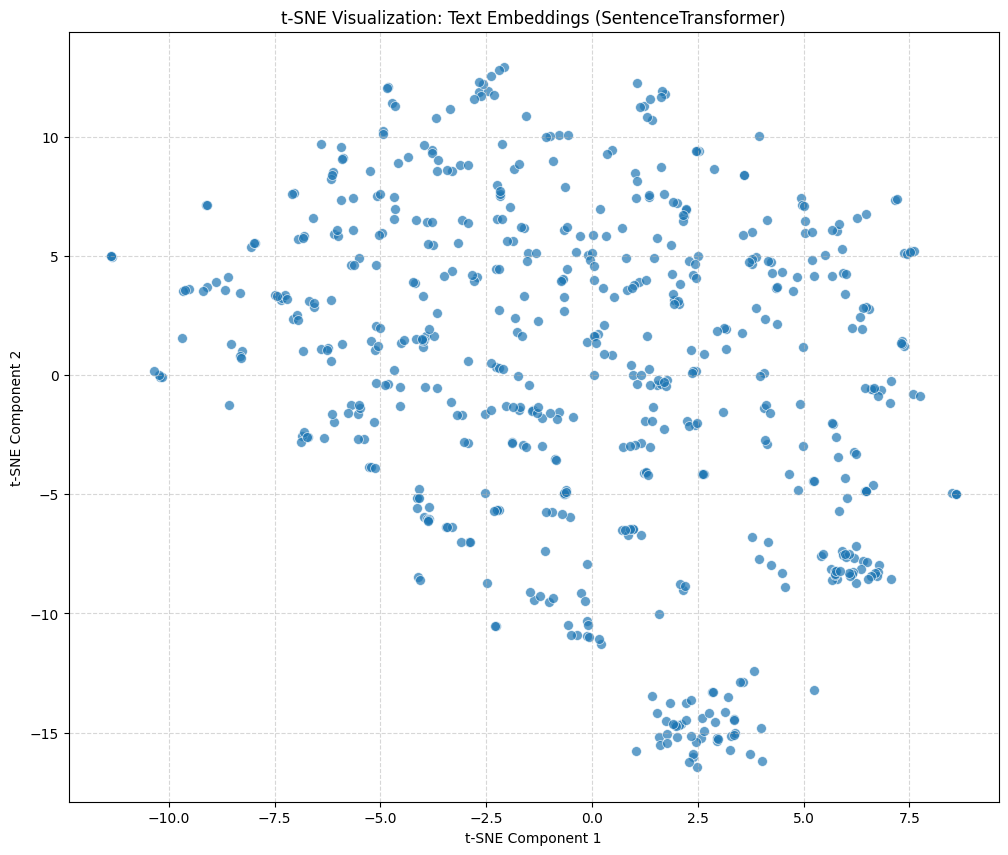

t-SNE plot for 'Text Embeddings (SentenceTransformer)' generated.

Running t-SNE on 322 embeddings for 'Image Embeddings (CLIP)' (this can take time)...
  Input array shape: (322, 512)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


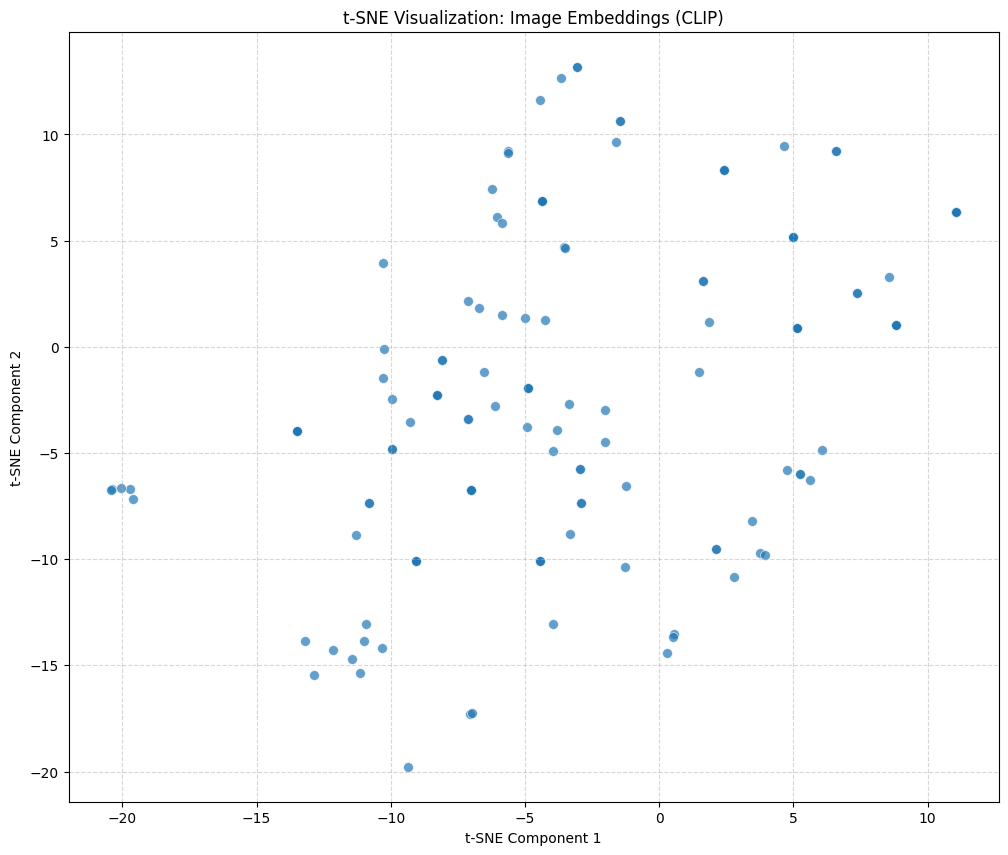

t-SNE plot for 'Image Embeddings (CLIP)' generated.


In [21]:
# --- Phase 6: Embedding Visualization (Revised) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA # Keep PCA import if needed later
import warnings # To suppress specific warnings if needed

# --- Load or Access Embeddings ---
# (Keep the loading/accessing logic from the original cell)
# Assume text_embeddings_for_vis, text_labels_for_vis,
# image_embeddings_for_vis, image_labels_for_vis are populated from the previous part of this cell

print("\n--- Preparing Embeddings for Visualization ---")

# Initialize lists
text_embeddings_for_vis = []
text_labels_for_vis = []
image_embeddings_for_vis = []
image_labels_for_vis = []

# Extract text embeddings
if 'text_docs_to_embed' in globals() and 'text_embedder' in globals() and 'text_vector_store' in globals():
    print("Extracting text embeddings...")
    try:
        if text_vector_store and hasattr(text_vector_store.index, 'reconstruct_n'):
             num_text_vectors = text_vector_store.index.ntotal
             # Ensure text_docs_to_embed has enough elements
             if len(text_docs_to_embed) >= num_text_vectors:
                 text_embeddings_for_vis = [text_vector_store.index.reconstruct(i) for i in range(num_text_vectors)]
                 text_labels_for_vis = [f"{doc.metadata.get('source_pdf', '?')}_p{doc.metadata.get('page', '?')}"
                                       for doc in text_docs_to_embed[:num_text_vectors]]
                 print(f"  -> Retrieved {len(text_embeddings_for_vis)} text vectors from FAISS index.")
             else:
                 print(f"  -> Mismatch between FAISS index size ({num_text_vectors}) and text docs list size ({len(text_docs_to_embed)}). Text visualization skipped.")

        else:
             print("  -> Cannot reconstruct text vectors from FAISS store or store not available. Text visualization skipped.")
    except Exception as e:
        print(f"  -> Error retrieving text vectors from FAISS: {e}. Text visualization skipped.")
else:
    print("Text documents, embedder, or vector store not found for visualization.")

# Use existing image embeddings
if 'image_embeddings_list' in globals() and 'valid_image_docs' in globals():
    print("Using existing image embeddings...")
    # Filter out potential None entries from image_embeddings_list
    valid_indices = [i for i, emb in enumerate(image_embeddings_list) if emb is not None]
    if len(valid_indices) != len(image_embeddings_list):
         print(f"  -> Warning: Filtered out {len(image_embeddings_list) - len(valid_indices)} None embeddings from image list.")

    image_embeddings_for_vis = [image_embeddings_list[i] for i in valid_indices]
    # Ensure valid_image_docs matches the filtered embeddings
    if len(valid_image_docs) == len(image_embeddings_list): # Check if valid_image_docs needs filtering too
         image_labels_for_vis = [f"IMG_{valid_image_docs[i].metadata.get('original_filename', '?')}" for i in valid_indices]
    else:
         # If valid_image_docs was already filtered correctly in Phase 2/3
         image_labels_for_vis = [f"IMG_{doc.metadata.get('original_filename', '?')}" for doc in valid_image_docs]
         if len(image_labels_for_vis) != len(image_embeddings_for_vis):
              print("  -> Warning: Mismatch between filtered image embeddings and image labels count. Labels might be incorrect.")
              # Fallback or adjust label creation as needed
              image_labels_for_vis = [f"IMG_{i}" for i in range(len(image_embeddings_for_vis))]


    print(f"  -> Found {len(image_embeddings_for_vis)} valid image vectors.")
else:
    print("Image embeddings list or valid image documents not found for visualization.")


# --- Function to run t-SNE and plot ---
def run_tsne_and_plot(embeddings, labels, plot_title):
    if not embeddings:
        print(f"\nNo embeddings provided for '{plot_title}'. Skipping visualization.")
        return
    if len(embeddings) <= 1:
        print(f"\nNot enough embeddings ({len(embeddings)}) available to run visualization for '{plot_title}'.")
        return

    print(f"\nRunning t-SNE on {len(embeddings)} embeddings for '{plot_title}' (this can take time)...")

    # Check if embeddings are already numpy arrays, if not convert
    if not isinstance(embeddings[0], np.ndarray):
         embeddings = [np.array(emb).astype(np.float32) for emb in embeddings]

    # Ensure all embeddings have the same shape before stacking
    first_shape = embeddings[0].shape
    if not all(emb.shape == first_shape for emb in embeddings):
        print(f"Error: Embeddings for '{plot_title}' have inconsistent shapes. Example shapes: {[emb.shape for emb in embeddings[:5]]}. Skipping plot.")
        # Attempt to fix by padding or resizing (advanced, may distort data) or skip
        return # Skip for now

    try:
        embeddings_array = np.vstack(embeddings).astype(np.float32) # Stack into a 2D array
    except ValueError as e:
         print(f"Error: Could not stack embeddings for '{plot_title}' into a NumPy array: {e}. Check individual embedding shapes and types. Skipping plot.")
         return

    print(f"  Input array shape: {embeddings_array.shape}")

    # Check for NaNs or Infs
    if np.isnan(embeddings_array).any() or np.isinf(embeddings_array).any():
        print(f"Error: Embeddings array for '{plot_title}' contains NaN or Inf values. Attempting to remove affected rows.")
        nan_inf_mask = ~np.any(np.isnan(embeddings_array) | np.isinf(embeddings_array), axis=1)
        embeddings_array = embeddings_array[nan_inf_mask]
        labels = [labels[i] for i, keep in enumerate(nan_inf_mask) if keep]
        print(f"  Proceeding with {embeddings_array.shape[0]} valid embeddings after cleaning.")
        if embeddings_array.shape[0] <= 1:
             print("  Not enough valid embeddings remaining after cleaning. Skipping plot.")
             return

    # Adjust perplexity based on number of samples
    perplexity_value = min(30, embeddings_array.shape[0] - 1)
    if perplexity_value <= 0:
         print(f"Error: Not enough samples ({embeddings_array.shape[0]}) for t-SNE in '{plot_title}' (perplexity must be > 0). Skipping plot.")
         return

    # Suppress specific UserWarning about PCA initialization if desired
    # warnings.filterwarnings("ignore", message=".*The PCA initialization.*")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=300, init='pca', learning_rate='auto')
    # warnings.resetwarnings() # Reset warnings filter

    try:
        embeddings_2d = tsne.fit_transform(embeddings_array)

        # Ensure labels list matches the potentially reduced embeddings_2d count
        if len(labels) != embeddings_2d.shape[0]:
             print(f"Warning: Label count ({len(labels)}) mismatch after t-SNE ({embeddings_2d.shape[0]}). Truncating labels.")
             labels = labels[:embeddings_2d.shape[0]]

        df_plot = pd.DataFrame({
            'x': embeddings_2d[:, 0],
            'y': embeddings_2d[:, 1],
            'label': labels
        })

        plt.figure(figsize=(12, 10))
        sns.scatterplot(
            data=df_plot,
            x='x',
            y='y',
            s=50, # Point size
            alpha=0.7
        )
        plt.title(f't-SNE Visualization: {plot_title}')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        print(f"t-SNE plot for '{plot_title}' generated.")

    except ValueError as ve:
         print(f"Error during t-SNE calculation for '{plot_title}': {ve}")
         print("This might be due to issues like insufficient samples after filtering NaNs, incompatible perplexity, or other data problems.")
    except Exception as e:
        print(f"An unexpected error occurred during t-SNE or plotting for '{plot_title}': {e}")

# --- Run Visualization Separately ---
run_tsne_and_plot(text_embeddings_for_vis, text_labels_for_vis, "Text Embeddings (SentenceTransformer)")
run_tsne_and_plot(image_embeddings_for_vis, image_labels_for_vis, "Image Embeddings (CLIP)")

In [22]:
import torch

if torch.cuda.is_available():
  print("CUDA is available! Training on GPU.")
  device = torch.device('cuda')
else:
  print("CUDA is not available. Training on CPU.")
  device = torch.device('cpu')

print(f"Current device: {device}")

CUDA is available! Training on GPU.
Current device: cuda


In [23]:
# Phase 5 - Step 1: Install Libraries
!pip install streamlit pyngrok --quiet
print("Streamlit and pyngrok installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.4 MB/s eta 0:00:00
Streamlit and pyngrok installed.


In [24]:
# Phase 5 - Step 2b: Create Combined Inference Function for UI
# Ensure rag_prompt and run_mistral_inference are defined and models are loaded

def get_rag_response(query: str):
    """
    Retrieves context, generates prompt, runs LLM, and returns answer + sources.
    """
    # 1. Retrieve relevant documents
    retrieved_docs_with_scores = multimodal_retrieve(query, num_text=k_text, num_image=k_image)

    if not retrieved_docs_with_scores:
        return "Could not retrieve relevant context.", []

    # 2. Format context for LLM
    # Ensure format_context function is defined/accessible
    context_for_llm = format_context(retrieved_docs_with_scores)

    # 3. Create the prompt string using the Mistral template
    # Ensure rag_prompt (PromptTemplate) is defined
    prompt_string = rag_prompt.format(context=context_for_llm, question=query)

    # 4. Run inference
    # Ensure run_mistral_inference function is defined and model/tokenizer are loaded
    try:
        answer = run_mistral_inference(prompt_string)
    except Exception as e:
        print(f"Error during model generation in get_rag_response: {e}")
        answer = f"Error during generation: {e}"

    # 5. Prepare sources for display
    sources = []
    seen_content = set()
    for doc, score in retrieved_docs_with_scores:
         content_key = doc.page_content[:100] # Use a portion to check uniqueness
         if content_key not in seen_content:
             metadata = doc.metadata
             source_pdf = metadata.get('source_pdf', 'Unknown')
             page = metadata.get('page', metadata.get('page_number', 'N/A'))
             doc_type = "Image" if metadata.get('type') == 'image' else "Text"
             # Optionally add a snippet of the content
             # content_snippet = doc.page_content[:80] + "..."
             sources.append(f"Type: {doc_type}, Source: {source_pdf}, Page: {page}, Score: {score:.4f}")
             seen_content.add(content_key)
         if len(sources) >= 5: # Limit displayed sources if needed
             break


    return answer, sources

# --- Test the function (Optional) ---
test_query = "What are financial statements?"
test_answer, test_sources = get_rag_response(test_query)
print("Test Answer:", test_answer)
print("Test Sources:", test_sources)


Retrieving top 5 text documents for query: 'What are financial statements?'
 -> Found 5 text results.

Retrieving top 5 image documents for query: 'What are financial statements?'
 -> Found 5 image results.
Retrieved 10 multimodal results for query: 'What are financial statements?'
Test Answer: Based on the provided context, financial statements are written records that illustrate the business activities and financial performance of a company. They typically include a balance sheet, an income statement, and a statement of cash flows.
Test Sources: ['Type: Text, Source: 2. financials.pdf, Page: 2, Score: 0.4316', 'Type: Text, Source: 2. financials.pdf, Page: 3, Score: 0.5231', 'Type: Text, Source: 2. financials.pdf, Page: 0, Score: 0.5414', 'Type: Text, Source: 2. financials.pdf, Page: 29, Score: 0.5519', 'Type: Text, Source: 2. financials.pdf, Page: 3, Score: 0.5656']


# Phase 5

In [25]:
# Phase 5 - Step 1: Install Libraries
!pip install streamlit pyngrok --quiet
print("Streamlit and pyngrok installed.")

Streamlit and pyngrok installed.


In [26]:
# Phase 5 - Step 2b: Create Combined Inference Function for UI
# Ensure rag_prompt and run_mistral_inference are defined and models are loaded

def get_rag_response(query: str):
    """
    Retrieves context, generates prompt, runs LLM, and returns answer + sources.
    """
    # 1. Retrieve relevant documents
    retrieved_docs_with_scores = multimodal_retrieve(query, num_text=k_text, num_image=k_image)

    if not retrieved_docs_with_scores:
        return "Could not retrieve relevant context.", []

    # 2. Format context for LLM
    # Ensure format_context function is defined/accessible
    context_for_llm = format_context(retrieved_docs_with_scores)

    # 3. Create the prompt string using the Mistral template
    # Ensure rag_prompt (PromptTemplate) is defined
    prompt_string = rag_prompt.format(context=context_for_llm, question=query)

    # 4. Run inference
    # Ensure run_mistral_inference function is defined and model/tokenizer are loaded
    try:
        answer = run_mistral_inference(prompt_string)
    except Exception as e:
        print(f"Error during model generation in get_rag_response: {e}")
        answer = f"Error during generation: {e}"

    # 5. Prepare sources for display
    sources = []
    seen_content = set()
    for doc, score in retrieved_docs_with_scores:
         content_key = doc.page_content[:100] # Use a portion to check uniqueness
         if content_key not in seen_content:
             metadata = doc.metadata
             source_pdf = metadata.get('source_pdf', 'Unknown')
             page = metadata.get('page', metadata.get('page_number', 'N/A'))
             doc_type = "Image" if metadata.get('type') == 'image' else "Text"
             # Optionally add a snippet of the content
             # content_snippet = doc.page_content[:80] + "..."
             sources.append(f"Type: {doc_type}, Source: {source_pdf}, Page: {page}, Score: {score:.4f}")
             seen_content.add(content_key)
         if len(sources) >= 5: # Limit displayed sources if needed
             break


    return answer, sources

# --- Test the function (Optional) ---
# test_query = "What are financial statements?"
# test_answer, test_sources = get_rag_response(test_query)
# print("Test Answer:", test_answer)
# print("Test Sources:", test_sources)

In [27]:
%%writefile app.py
import streamlit as st
# --- Core Python/Data Handling Imports ---
import io
import os
import numpy as np
import faiss
import pickle
import time # Added for potential delays

# --- DL/ML Imports ---
import torch
from PIL import Image
from transformers import (CLIPProcessor, CLIPModel, CLIPTokenizer,
                          AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig) # Added CLIP imports

# --- Langchain Imports ---
from langchain_community.vectorstores import FAISS # For loading FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough


# ==============================================================================
# !!! THIS MUST BE THE VERY FIRST STREAMLIT COMMAND !!!
# ==============================================================================
st.set_page_config(layout="wide", page_title="Multimodal RAG System")

# ==============================================================================
# Resource Loading Function (Cached)
# ==============================================================================
@st.cache_resource # Decorator to cache the loaded resources
def load_all_resources():
    print("Attempting to load resources...")
    load_errors = [] # Keep track of errors during loading

    # --- Determine Device ---
    device_for_load = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading resources on device: {device_for_load}")

    # --- Load Text Embedder ---
    text_embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
    text_embedder_loaded = None
    try:
        text_embedder_loaded = HuggingFaceEmbeddings(
            model_name=text_embedding_model_name,
            model_kwargs={'device': device_for_load},
            encode_kwargs={'normalize_embeddings': True}
        )
        print("Text Embedder loaded successfully.")
    except Exception as e:
        print(f"ERROR loading Text Embedder: {e}")
        load_errors.append(f"Text Embedder ({text_embedding_model_name}): {e}")

    # --- Load CLIP Model/Processor/Tokenizer ---
    image_embedding_model_name = "openai/clip-vit-base-patch32"
    image_model_clip_loaded, image_processor_clip_loaded, clip_tokenizer_loaded = None, None, None
    try:
        image_model_clip_loaded = CLIPModel.from_pretrained(image_embedding_model_name).to(device_for_load)
        image_processor_clip_loaded = CLIPProcessor.from_pretrained(image_embedding_model_name)
        clip_tokenizer_loaded = CLIPTokenizer.from_pretrained(image_embedding_model_name)
        print("CLIP Model/Processor/Tokenizer loaded successfully.")
    except Exception as e:
        print(f"ERROR loading CLIP resources: {e}")
        load_errors.append(f"CLIP ({image_embedding_model_name}): {e}")

    # --- Load FAISS Indices and Map ---
    faiss_image_index_path = "faiss_image_index.faiss" # Make sure this file exists in Colab
    image_doc_map_path = "faiss_image_doc_map.pkl" # Make sure this file exists in Colab
    text_vector_store_path = "faiss_text_index" # *** YOU MUST HAVE SAVED THIS in your notebook ***
                                                 # using text_vector_store.save_local("faiss_text_index")
    img_index_manual_loaded, image_doc_map_loaded, text_vector_store_loaded = None, None, None
    try:
        if os.path.exists(faiss_image_index_path):
            img_index_manual_loaded = faiss.read_index(faiss_image_index_path)
            print("Image FAISS index loaded successfully.")
        else:
             print(f"ERROR: Image FAISS index file not found at {faiss_image_index_path}")
             load_errors.append("Image FAISS index file not found.")

        if os.path.exists(image_doc_map_path):
            with open(image_doc_map_path, "rb") as f:
                image_doc_map_loaded = pickle.load(f)
            print("Image document map loaded successfully.")
        else:
             print(f"ERROR: Image doc map file not found at {image_doc_map_path}")
             load_errors.append("Image doc map file not found.")

    except Exception as e:
         print(f"ERROR loading Image FAISS index/map: {e}")
         load_errors.append(f"Image FAISS index/map: {e}")

    # Load text store - REQUIRES the embedder object AND the saved index folder
    try:
        if text_embedder_loaded and os.path.exists(text_vector_store_path):
             text_vector_store_loaded = FAISS.load_local(
                 text_vector_store_path,
                 text_embedder_loaded,
                 allow_dangerous_deserialization=True # Often needed
             )
             print("Text FAISS index loaded successfully.")
        elif not text_embedder_loaded:
             print("ERROR: Cannot load Text FAISS index without a loaded text embedder.")
             load_errors.append("Text FAISS index requires Text Embedder, which failed to load.")
        else:
             print(f"ERROR: Text FAISS index folder not found at {text_vector_store_path}. Did you save it using text_vector_store.save_local()?")
             load_errors.append(f"Text FAISS index folder '{text_vector_store_path}' not found.")
    except Exception as e:
         print(f"ERROR loading Text FAISS index: {e}")
         load_errors.append(f"Text FAISS index loading: {e}")


    # --- Load LLM ---
    llm_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
    model_loaded, tokenizer_loaded = None, None
    try:
        print("Loading LLM model (this might take a while)...")
        bnb_config_loaded = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=False,
        )
        model_loaded = AutoModelForCausalLM.from_pretrained(
            llm_model_id,
            quantization_config=bnb_config_loaded,
            device_map="auto", # Let transformers handle device placement
            torch_dtype=torch.bfloat16,
            trust_remote_code=True
        )
        tokenizer_loaded = AutoTokenizer.from_pretrained(llm_model_id)
        if tokenizer_loaded.pad_token is None:
            tokenizer_loaded.pad_token = tokenizer_loaded.eos_token
        print("LLM Model/Tokenizer loaded successfully.")
    except ImportError:
        print("ERROR loading LLM: bitsandbytes library not found or import failed.")
        load_errors.append("LLM loading failed (bitsandbytes error).")
    except Exception as e:
        print(f"ERROR loading LLM: {e}") # Use print
        load_errors.append(f"LLM ({llm_model_id}): {e}")

    print("Resource loading function finished.")
    # Return loaded resources AND any errors encountered
    return (device_for_load, text_embedder_loaded, text_vector_store_loaded,
            image_model_clip_loaded, image_processor_clip_loaded, clip_tokenizer_loaded,
            img_index_manual_loaded, image_doc_map_loaded, model_loaded, tokenizer_loaded, load_errors)

# ==============================================================================
# Global Variables (Loaded via Cache)
# ==============================================================================
(device, text_embedder, text_vector_store, image_model_clip, image_processor_clip,
 clip_tokenizer, img_index_manual, image_doc_map, model, tokenizer, load_errors) = load_all_resources()

# --- Configuration ---
k_text = 5
k_image = 5
max_new_tokens = 512 # For LLM generation

# ==============================================================================
# Define Helper Functions HERE (within app.py)
# ==============================================================================

# --- Function to embed images using CLIP (needed for image retrieval) ---
# (Copy your definition of embed_image_clip here)
def embed_image_clip(image_path):
    global image_processor_clip, image_model_clip, device
    if not all([image_processor_clip, image_model_clip, device]): return None
    try:
        image = Image.open(image_path).convert("RGB")
        with torch.no_grad():
            inputs = image_processor_clip(images=image, return_tensors="pt").to(device)
            image_features = image_model_clip.get_image_features(**inputs)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        return image_features.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"Warning: Error embedding image {os.path.basename(image_path)}: {e}") # Use print
        return None

# --- Helper function for CLIP Text Embedding ---
# (Copy your definition of embed_text_clip here)
def embed_text_clip(text: str):
    global clip_tokenizer, image_model_clip, device
    if not all([clip_tokenizer, image_model_clip, device]): return None
    try:
        inputs = clip_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
        with torch.no_grad():
            text_features = image_model_clip.get_text_features(**inputs)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        return text_features.squeeze(0).cpu().numpy()
    except Exception as e:
        print(f"Warning: Error embedding text '{text}' with CLIP: {e}") # Use print
        return None

# --- Retrieval Functions ---
# (Copy your definitions of retrieve_text, retrieve_images, multimodal_retrieve here)
def retrieve_text(query: str, k: int = k_text):
    global text_vector_store
    if not text_vector_store: return []
    try:
        results = text_vector_store.similarity_search_with_score(query, k=k)
        print(f" -> Found {len(results)} text results.")
        return results
    except Exception as e:
        print(f"ERROR during text retrieval: {e}") # Use print
        return []

def retrieve_images(text_query: str, k: int = k_image):
    global img_index_manual, image_doc_map
    if not all([img_index_manual, image_doc_map]): return []
    try:
        query_embedding_clip = embed_text_clip(text_query)
        if query_embedding_clip is None: return []
        query_embedding_clip_np = np.array([query_embedding_clip], dtype=np.float32)
        distances, indices = img_index_manual.search(query_embedding_clip_np, k)
        results = []
        if indices.size > 0:
            for i, idx in enumerate(indices[0]):
                if idx != -1:
                    score = distances[0][i]
                    metadata = image_doc_map.get(int(idx))
                    if metadata:
                         ocr_text = metadata.get('ocr_text', '')
                         page_content = f"Image file: {metadata.get('original_filename', '?')}. OCR Text: {ocr_text}"
                         retrieved_doc = Document(page_content=page_content, metadata=metadata)
                         results.append((retrieved_doc, score))
        print(f" -> Found {len(results)} image results.")
        return results
    except Exception as e:
        print(f"ERROR during image retrieval: {e}") # Use print
        return []

def multimodal_retrieve(query: str, num_text: int = k_text, num_image: int = k_image):
    text_results = retrieve_text(query, k=num_text)
    image_results = retrieve_images(query, k=num_image)
    all_results = text_results + image_results
    all_results.sort(key=lambda x: x[1])
    print(f"Retrieved {len(all_results)} multimodal results for query: '{query}'")
    return all_results

# --- Format Retrieved Context ---
# (Copy your definition of format_context here)
def format_context(docs_with_scores):
    context_parts = []
    seen_content = set()
    max_context_len = 3800 # Adjust based on model limits
    current_len = 0
    for i, (doc, score) in enumerate(docs_with_scores):
        content = doc.page_content
        if content not in seen_content:
            metadata = doc.metadata
            is_image = metadata.get('type') == 'image'
            source = metadata.get('source_pdf', 'Unknown Source')
            page = metadata.get('page', metadata.get('page_number', 'N/A'))
            doc_type = "Image" if is_image else "Text"
            content_for_prompt = content
            if is_image and 'OCR Text' not in content:
                 ocr_text = metadata.get('ocr_text', '')
                 if ocr_text: # Only add if OCR text exists
                      content_for_prompt += f"\\nExtracted OCR Text: {ocr_text}"

            entry = f"Source Document: {source}, Page: {page}, Type: {doc_type}\\nContent: {content_for_prompt}\\n---"

            # Check length before adding
            if current_len + len(entry) <= max_context_len:
                 context_parts.append(entry)
                 seen_content.add(content)
                 current_len += len(entry) + 2 # +2 for newline separators
            else:
                 print(f"Context length limit reached ({current_len}/{max_context_len}). Stopping context addition.")
                 break # Stop adding more context if limit is reached

    return "\\n\\n".join(context_parts)


# --- Custom Inference Function ---
# (Copy your definition of run_mistral_inference here)
def run_mistral_inference(prompt_string: str) -> str:
    global model, tokenizer, device, max_new_tokens
    if not model or not tokenizer:
        return "Error: LLM Model or Tokenizer not loaded properly."
    messages = [{"role": "user", "content": prompt_string}]
    try:
        inputs = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)
        with torch.no_grad():
             outputs = model.generate(
                 inputs,
                 max_new_tokens=max_new_tokens,
                 pad_token_id=tokenizer.eos_token_id,
                 do_sample=True, # You might adjust sampling parameters
                 temperature=0.6,
                 top_p=0.9,
             )
        input_token_len = inputs.shape[1]
        generated_tokens = outputs[:, input_token_len:]
        decoded_output = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
        return decoded_output.strip()
    except Exception as e:
        print(f"Error during model generation: {e}") # Use print
        return f"Error during generation: {e}"


# --- Define the Main RAG Function ---
# (This is the function your Streamlit UI calls)
def get_rag_response(query: str):
    global k_text, k_image # Ensure k values are accessible

    # 1. Retrieve
    retrieved_docs_with_scores = multimodal_retrieve(query, num_text=k_text, num_image=k_image)
    if not retrieved_docs_with_scores:
        return "Could not retrieve relevant context.", []

    # 2. Format context for LLM
    context_for_llm = format_context(retrieved_docs_with_scores)

    # 3. Create the prompt template string (Mistral format)
    prompt_template_str_mistral = """<s>[INST] You are an assistant tasked with answering questions based ONLY on the context provided below.
If the context does not contain the answer, state "Based on the provided context, I cannot answer the question.".
Do not use any prior knowledge. Be concise.

Context:
{context}

Question: {question} [/INST]
"""
    rag_prompt_template = PromptTemplate.from_template(prompt_template_str_mistral)
    prompt_string = rag_prompt_template.format(context=context_for_llm, question=query)


    # 4. Run inference
    answer = run_mistral_inference(prompt_string)

    # 5. Prepare sources for display (limited to top 5 unique retrieved)
    sources = []
    seen_content = set()
    for doc, score in retrieved_docs_with_scores:
         content_key = doc.page_content[:100] # Use a portion to check uniqueness
         if content_key not in seen_content:
             metadata = doc.metadata
             source_pdf = metadata.get('source_pdf', 'Unknown')
             page = metadata.get('page', metadata.get('page_number', 'N/A'))
             doc_type = "Image" if metadata.get('type') == 'image' else "Text"
             sources.append(f"Type: {doc_type}, Source: {source_pdf}, Page: {page}, Score: {score:.4f}")
             seen_content.add(content_key)
             if len(sources) >= 5: # Limit to top 5 unique sources for display
                 break
    return answer, sources

# ==============================================================================
# Streamlit UI Code
# ==============================================================================

# --- Display Loading Errors (if any) ---
if load_errors:
    st.error("There were errors loading resources. App functionality may be limited:")
    for error in load_errors:
        st.error(f"- {error}")

# --- Main UI Elements ---
st.title("📚 Multimodal RAG System")
st.write("Ask questions about the provided PDF documents (Annual Report, Financials, FYP Handbook).")

# Initialize Session State
if 'messages' not in st.session_state:
    st.session_state.messages = []

# User Input
col1, col2 = st.columns(2)
with col1:
    text_query = st.text_input("Enter your text query:")
with col2:
    uploaded_image = st.file_uploader("Upload an image query (Optional - Not fully implemented yet):", type=["png", "jpg", "jpeg"])

submit_button = st.button("Ask")

# Processing and Output
# Check if core resources needed for processing are loaded before proceeding
core_resources_loaded = all([text_vector_store, img_index_manual, image_doc_map, model, tokenizer,
                             text_embedder, image_model_clip, clip_tokenizer, image_processor_clip])

if submit_button and text_query:
    if core_resources_loaded:
        with st.spinner("Retrieving context and generating answer..."):
            try:
                answer, sources = get_rag_response(text_query)

                st.subheader("Answer:")
                st.markdown(answer)

                if sources:
                    st.subheader("Retrieved Sources (Top 5 Unique):")
                    for source in sources:
                        st.text(source)
                else:
                    st.warning("No sources were retrieved for display.")

            except Exception as e:
                st.error(f"An error occurred during query processing: {e}")
    else:
        st.error("Cannot process query because essential resources failed to load.")

elif submit_button and not text_query:
    st.warning("Please enter a text query.")

# Image Query Handling Placeholder
if uploaded_image is not None:
    st.image(uploaded_image, caption="Uploaded Image Query", use_column_width=True)
    st.warning("Image query functionality is not fully implemented in this UI example.")

Writing app.py


In [28]:
# Phase 5 - Step 4: Ngrok Authentication (Run only once per session if needed)
# Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual token
!ngrok authtoken 2wSralQIB3Fkc0qOjoAFUawOZsv_4zou6DE1MF84C4KZXmt2o

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [29]:
# Phase 5 - Step 5: Run Streamlit App and Create Tunnel
import subprocess
import os
from pyngrok import ngrok
import time

# Kill any existing ngrok/streamlit processes
!pkill ngrok
!pkill streamlit

# Make sure the app.py file exists
if not os.path.exists("app.py"):
    print("Error: app.py not found. Please run Step 3 first.")
else:
    # Start streamlit in background
    proc = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501", "--server.headless", "true"])
    print("Starting Streamlit app...")
    time.sleep(5) # Give Streamlit time to start

    # Setup ngrok tunnel
    try:
        public_url = ngrok.connect(8501)
        print("="*50)
        print("Streamlit App URL:", public_url)
        print("="*50)
    except Exception as e:
        print(f"Error starting ngrok: {e}")
        print("Make sure you've authenticated ngrok (Step 4).")
        print("You might need to restart the Colab runtime and run steps 1, 4, and 5 again.")

# Note: The app runs in the background. To stop it, you might need to interrupt/restart the Colab runtime.
# The ngrok URL will allow you to access the UI from your browser.

Starting Streamlit app...
Streamlit App URL: NgrokTunnel: "https://84fa-34-53-95-112.ngrok-free.app" -> "http://localhost:8501"


In [30]:
print('Hello')

Hello
